In [1]:
#install numpy, pandas, matplolib, tensorflow, sklearn, pandas_datareader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from time import sleep
import os

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

import pandas_datareader as pd_dr

In [2]:
#Données d'entrainement doivent être différentes des données de test donc on s'arrete en 2019...
training_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2015,1,1), dt.datetime(2019,12,30) )
training_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999
...,...,...,...,...,...,...
2019-12-27,7363.529297,7189.934082,7238.141113,7290.088379,22777360996,7290.088379
2019-12-28,7399.041016,7286.905273,7289.031250,7317.990234,21365673026,7317.990234
2019-12-29,7513.948242,7279.865234,7317.647461,7422.652832,22445257702,7422.652832


In [3]:
#Preprocessing
training_data = training_data.drop(['Adj Close'], axis='columns')

scaler = MinMaxScaler( feature_range=(0,1) )

scaled_data = scaler.fit_transform( training_data ) 

scaled_data

array([[5.46875905e-03, 7.57837081e-03, 7.43762423e-03, 7.04715049e-03,
        3.90040572e-06],
       [5.23753975e-03, 7.55507677e-03, 7.10827975e-03, 7.08768095e-03,
        0.00000000e+00],
       [5.20287727e-03, 5.82749549e-03, 7.14802285e-03, 5.33037003e-03,
        5.58646087e-04],
       ...,
       [3.67365217e-01, 3.78051927e-01, 3.70008086e-01, 3.74990337e-01,
        4.97526730e-01],
       [3.64390763e-01, 3.77862744e-01, 3.75325771e-01, 3.68279031e-01,
        5.07036579e-01],
       [3.58377151e-01, 3.72197021e-01, 3.68805505e-01, 3.63134123e-01,
        4.69203629e-01]])

In [4]:
#Fragmente le dataset en plusieurs packets
chunks_size = 90

x_train, y_train = list(), list()

for x in range( chunks_size, len(scaled_data) ):
    x_train.append(scaled_data[x-chunks_size:x])
    y_train.append(scaled_data[x])
    
x_train, y_train = np.array(x_train), np.array(y_train)

In [31]:
#Neural network
model = Sequential() #-> most common model, which is a linear stack of layers

model.add( LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], 5)) )
#-> couche à creuser (https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
model.add( Dropout(0.2) ) #-> chaque neurone à 20% de chance d'être désactivé, à faire varier entre 0,1 et 0,5
#-> Dropout : réduction d'overfitting lors de l'entrainement du model.
# Le principe : désactivation de certains neurones à chaque epoch, cela casse la synchronicité des neurones entre 
# voisins d'une même couche et force le modèle à exploiter chaque neurone individuellement.
model.add( LSTM(units=80, return_sequences=True) )
model.add( Dropout(0.3) ) 
model.add( LSTM(units=120) )
model.add( Dropout(0.4) ) 
model.add( Dense(units=5) ) #-> seulement la valeur y est attendue en sorti ...

model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split=0.1)
#tester la fonction d'activation relu avec un activation = 'relu'
#tester avec un batch size de 50

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 90, 60)            15840     
                                                                 
 dropout_3 (Dropout)         (None, 90, 60)            0         
                                                                 
 lstm_4 (LSTM)               (None, 90, 80)            45120     
                                                                 
 dropout_4 (Dropout)         (None, 90, 80)            0         
                                                                 
 lstm_5 (LSTM)               (None, 120)               96480     
                                                                 
 dropout_5 (Dropout)         (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                

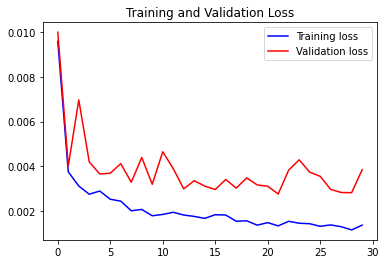

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

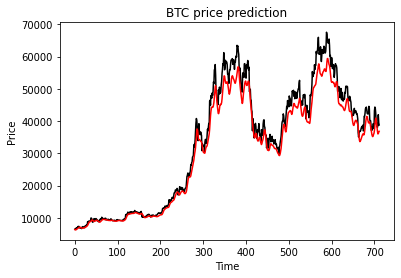

In [33]:
#Test du modèle
testing_data = pd_dr.DataReader( 'BTC-USD', 'yahoo', dt.datetime(2020,1,1), dt.datetime.now() )
testing_data = testing_data.drop(['Adj Close'], axis='columns')

actual_prices = testing_data['Close'].values
actual_prices = actual_prices[89:x]

#actual_prices = actual_prices * scaler.scale_[3]

model_inputs = testing_data.values

model_inputs = scaler.fit_transform(model_inputs)

x_test = list()
for x in range( chunks_size, len(model_inputs) ):
    x_test.append( model_inputs[x-chunks_size:x] )
    
x_test = np.array(x_test)


prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)[:, [3]]

#prediction_prices.shape

plt.plot(actual_prices, color='black', label='actual_prices')
plt.plot(prediction_prices, color='red', label='predicted_prices')
plt.title('BTC price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()